# PSPNet
論文  
https://arxiv.org/pdf/1612.01105.pdf  
解説記事   
https://tarovel4842.hatenablog.com/entry/2019/11/15/180322  
https://blog.negativemind.com/2019/03/19/semantic-segmentation-by-pyramid-scene-parsing-network/  


In [92]:
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor
from tqdm import tqdm
import random, math, time


import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torchvision import transforms
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:

def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [3]:
for line in open('data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt'):
    print(line)

2007_000032

2007_000039

2007_000063

2007_000068

2007_000121

2007_000170

2007_000241

2007_000243

2007_000250

2007_000256

2007_000333

2007_000363

2007_000364

2007_000392

2007_000480

2007_000504

2007_000515

2007_000528

2007_000549

2007_000584

2007_000645

2007_000648

2007_000713

2007_000720

2007_000733

2007_000738

2007_000768

2007_000793

2007_000822

2007_000836

2007_000876

2007_000904

2007_001027

2007_001073

2007_001149

2007_001185

2007_001225

2007_001340

2007_001397

2007_001416

2007_001420

2007_001439

2007_001487

2007_001595

2007_001602

2007_001609

2007_001698

2007_001704

2007_001709

2007_001724

2007_001764

2007_001825

2007_001834

2007_001857

2007_001872

2007_001901

2007_001917

2007_001960

2007_002024

2007_002055

2007_002088

2007_002099

2007_002105

2007_002107

2007_002120

2007_002142

2007_002198

2007_002212

2007_002216

2007_002227

2007_002234

2007_002273

2007_002281

2007_002293

2007_002361

2007_002368

2007_002370


In [4]:
# 動作確認 ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


# Datasetの作成

In [5]:
class DataTransform:
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """
      
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train' : Compose([
                    Scale(scale=[0.5, 1.5]),
                    RandomRotation(angle=[-10, 10]),
                    RandomMirror(),
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std)]),
            'val' : Compose([
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std)
            ])}
            
    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


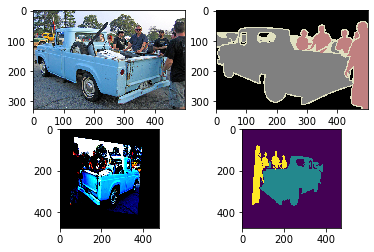

In [6]:
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(475, color_mean, color_std)
img = Image.open("data/VOCdevkit/VOC2012/JPEGImages/2010_002929.jpg")
anno_img = Image.open("data/VOCdevkit/VOC2012/SegmentationClass/2010_002929.png")

img_transformed, anno_img_transformed = transform('train', img, anno_img)
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
anno_img_transformed = anno_img_transformed.numpy()

fig = plt.figure()
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(anno_img)
plt.subplot(2,2,3)
plt.imshow(img_transformed)
plt.subplot(2,2,4)
plt.imshow(anno_img_transformed)

plt.show()

In [7]:
class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """
    
    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img
        
    def pull_item(self, index):
        img = Image.open(self.img_list[index])
        anno_img = Image.open(self.anno_list[index])
        
        img, anno_img = self.transform(self.phase, img, anno_img)
        return img, anno_img

In [8]:
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', 
                                                   transform=DataTransform(input_size=475, 
                                                                                                  color_mean=color_mean,
                                                                                                  color_std=color_std))
val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
                                                transform=DataTransform(input_size=475,
                                                                                               color_mean=color_mean,
                                                                                               color_std=color_std))

print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)

torch.Size([3, 475, 475])
torch.Size([475, 475])


# DataLoaderを作成

In [9]:
batch_size = 4

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size,
                                                              num_workers=4, shuffle=True)

val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size,
                                                              num_workers=4, shuffle=False)

dataloaders_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(dataloaders_dict['val'])
img, anno_img = next(batch_iterator)
print(img.size())
print(anno_img.size())

torch.Size([4, 3, 475, 475])
torch.Size([4, 475, 475])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


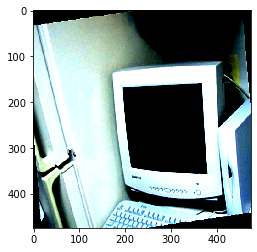

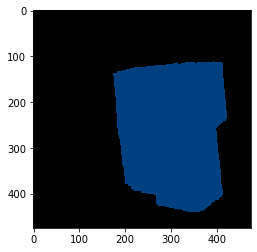

In [10]:
# 実行するたびに変わります

# 画像データの読み込み
# 画像処理後
index = 1
imges, anno_class_imges = train_dataset.__getitem__(index) 

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette() # 元画像のカラーパレットを取得

anno_class_img_val = anno_class_imges.numpy()
# mode=Pで画像を変換
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette) # 元のカラーパレットを当てはめる
plt.imshow(anno_class_img_val)
plt.show()


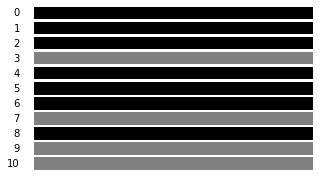

In [11]:
fig, axes_list = plt.subplots(11, 1, figsize=(5, 3))
for i, color in enumerate(p_palette[:11]):
    color_img = np.full((1, 10, 3), color, dtype=np.uint8)
    axes_list[i].imshow(color_img, aspect='auto')
    axes_list[i].set_axis_off()
    axes_list[i].text(-1, 0, i, va='center', ha='right', fontsize=10)

plt.show()

In [12]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        # パラメータ設定
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_sizeの1/8に

    
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Featureモジュールの途中をAuxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)


# 3.4 Featureモジュール
ResNetの解説スライド  
https://www.slideshare.net/KotaNagasato/resnet-82940994

In [13]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs


In [14]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase設定で入力を保存せずに出力を計算し、メモリ削減する

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs

In [15]:
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs

In [16]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )


In [17]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # スキップ結合
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)


In [18]:
class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)


# 3.5 Pyramid Poolingモジュール

In [19]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳み込み層の出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output


# 3.6 Decoder、AuxLossモジュール

In [20]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output


In [21]:
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output


# ネットワークモデル作成

In [26]:
# ファインチューニングでPSPNetを作成
# ADE20Kデータセットの学習済みモデルを使用、ADE20Kはクラス数が150です
net = PSPNet(n_classes=150)

# ADE20K学習済みパラメータをロード
state_dict = torch.load('weights/pspnet50_ADE20K.pth')
net.load_state_dict(state_dict)

# 分類用の畳み込み層を、出力数21のものにつけかえる
n_classes = 21
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None: # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)

net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)
print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [27]:
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [28]:
# ダミーデータの作成
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)

# 計算
outputs = net(dummy_img)
print(outputs[0].size())


torch.Size([2, 21, 475, 475])


# 損失関数を定義

In [29]:
class PSPLoss(nn.Module):
    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight
        
    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 4755]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """
        
        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduce='mean')
        
        return loss + self.aux_weight * loss_aux
    
criterion = PSPLoss(aux_weight=0.4)

# 最適化手法を設定

In [30]:
optimizer = optim.SGD([
    {'params':net.feature_conv.parameters(), 'lr':1e-3},
    {'params':net.feature_res_1.parameters(), 'lr':1e-3},
    {'params':net.feature_res_2.parameters(), 'lr':1e-3},
    {'params':net.feature_dilated_res_1.parameters(), 'lr':1e-3},
    {'params':net.feature_dilated_res_2.parameters(), 'lr':1e-3},
    {'params':net.pyramid_pooling.parameters(), 'lr':1e-3},
    {'params':net.decode_feature.parameters(), 'lr':1e-2},
    {'params':net.aux.parameters(), 'lr':1e-2},
    ], momentum=0.9, weight_decay=0.0001 )

# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1 - epoch/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

# 学習・検証を実施する

In [35]:
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    net.to(device)
    
    torch.backends.cudnn.benchmark = True
    
    # 画像の枚数
    num_train_imgs = len(dataloaders_dict['train'].dataset)
    num_val_imgs = len(dataloaders_dict['val'].dataset)
    batch_size = dataloaders_dict['train'].batch_size
    
    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3
    
    for epoch in range(num_epochs):
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                scheduler.step() # 最適化schedulerの更新
                optimizer.zero_grad()
                print('（train）')
                
            else:
                if ((epoch+1) % 5 == 0):  # 検証は5回に1回だけ行う
                    net.eval()
                    print('-------------')
                    print('（val）')
                else:
                    continue
                    
        
            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for images, anno_class_images in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if images.size(0) == 1:
                    continue
                    
                images = images.to(device)
                anno_class_images = anno_class_images.to(device)
                
                # multiple minibatchでのパラメータの更新
                if (phase == 'train') and (count ==0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier
                    
                 # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(images)
                    loss = criterion(outputs, anno_class_images.long()) / batch_multiplier
                    
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':  
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch
                        
                        if (iteration % 10 == 0):
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1
                
                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier
                        
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()      
        
        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")
        
    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/pspnet50_' +
               str(epoch+1) + '.pth')

In [36]:
# 学習・検証を実行する
num_epochs = 1
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)


-------------
Epoch 1/1
-------------
（train）


/home/nagae/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


イテレーション 10 || Loss: 0.2931 || 10iter: 6.2279 sec.
イテレーション 20 || Loss: 0.2449 || 10iter: 5.9220 sec.
イテレーション 30 || Loss: 0.0787 || 10iter: 5.9545 sec.
イテレーション 40 || Loss: 0.1897 || 10iter: 5.9788 sec.
イテレーション 50 || Loss: 0.1707 || 10iter: 5.9894 sec.
イテレーション 60 || Loss: 0.0718 || 10iter: 6.1272 sec.
イテレーション 70 || Loss: 0.0605 || 10iter: 6.1481 sec.
イテレーション 80 || Loss: 0.2253 || 10iter: 6.1500 sec.
イテレーション 90 || Loss: 0.1637 || 10iter: 6.3785 sec.
イテレーション 100 || Loss: 0.2274 || 10iter: 6.1919 sec.
イテレーション 110 || Loss: 0.1369 || 10iter: 6.3883 sec.
イテレーション 120 || Loss: 0.0901 || 10iter: 6.1287 sec.
イテレーション 130 || Loss: 0.1014 || 10iter: 6.2447 sec.
イテレーション 140 || Loss: 0.3758 || 10iter: 6.1114 sec.
イテレーション 150 || Loss: 0.1173 || 10iter: 6.2080 sec.
イテレーション 160 || Loss: 0.1908 || 10iter: 6.2617 sec.
イテレーション 170 || Loss: 0.1665 || 10iter: 6.2039 sec.
イテレーション 180 || Loss: 0.0921 || 10iter: 6.1453 sec.
イテレーション 190 || Loss: 0.1965 || 10iter: 6.2067 sec.
イテレーション 200 || Loss: 0.1335 || 10iter: 6

In [22]:
net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load("./weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


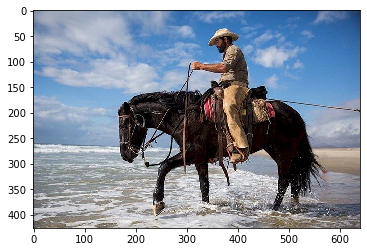

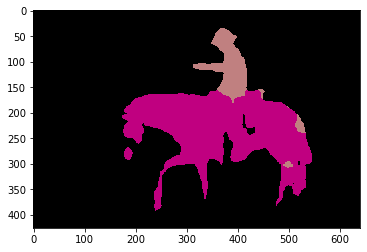

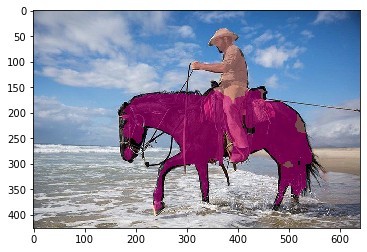

In [23]:
# 1. 元画像の表示
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

# 4. PSPNetで推論する
net.eval()
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])

# 5. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 6. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 150は透過度の大きさを指定している

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()



In [93]:
IoU = []

for index in tqdm(range(len(val_anno_list))):
    # 正解アノテーション画像
    anno_file_path = val_anno_list[index]
    anno_class_img = Image.open(anno_file_path)  # [高さ][幅][色RGB]

    # PSPNetで推論する
    net.eval()
    img, anno_class_img = val_dataset.__getitem__(index)
    x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
    outputs = net(x)
    y = outputs[0]  # AuxLoss側は無視
    
    # PSPNetの出力から最大クラスを求める
    y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
    y = np.argmax(y, axis=0)

    iou = sum(sum(y == anno_class_img.numpy())) / (475*475)
    IoU.append(iou)


100%|██████████| 1449/1449 [31:23<00:00,  1.30s/it]


In [98]:
print('IoU mean:{:.3f}, std:{:.3f}'.format(np.mean(IoU), np.std(IoU)))

IoU mean:0.891, std:0.126
